$\DeclareMathOperator*{\argmin}{argmin} $

Notes from [this excellent article](http://www.statsathome.com/2017/10/12/bayesian-decision-theory-made-ridiculously-simple/)

## Formalizing Decisions
The article starts, as so many math papers do, by framing the definitions. Justin introduces a number of useful notations and definitions which we will note here.

| Term | Notation | Definition |
|:----:|:--------:|:----------:|
| Decision Space | $\mathcal{A}$ | The space of all possible decisions |
| Decision | $a \in \mathcal{A}$ | A particular decision drawn from the decision space |
| Information Space | $\Theta$ | The space of all information for a particular decision |
| A piece of information | $\theta \in \Theta$ | A particular piece of information |
| Beliefs on \theta | $p(\theta)$ | The probability distribution reflecting our beliefs on the value of $\theta$ where it is uncertain | 

### Examples of Decisions
* If I am trying to decide a price to use for a cell phone, then the decision space might be the space of positive real numbers $a \in [0, + \infty )$
* If I am trying to decide between two brands of cereal, then the decision might simply be the set $\{a_1, a_2\}$

### Examples of Information
* In the cell phone case.  We might develop a model based on previous online listing in order to predict the probability the phone will be sold at a given price. In this case $\Theta \in [0, 1]$ and $\theta$ would be any particular probability for a given price. 
* For breakfast cereal we might use the grams of sugar per serving as a piece of information.  In this case we would have $\Theta \in \mathcal{R}^{2+}$, the positive quadrant of 2 dimensional real space, where $\theta_1$ and $\theta_2$ are the amounts of sugar in two selected cereals. 

### The Loss Function
At this point we know what our decisions are and we have information with which to make it.  However, we don't yet have a way of determining which decision is best, thus the loss function $\mathcal{L}$.  The crucial purpose of $\mathcal{L}$ is to quantify how good or bad a given decision $a$ is given some information $\theta$, typically as a real number.  We can thus generally think of loss/utility/acquisition functions as a mapping $$\mathcal{L}:\Theta \times \mathcal{A} \rightarrow \mathcal{R}$$

Defining a reasonable loss function is often one of the hardest parts of this problem, because it is subjective and has to capture everything that is meaningful to you. 

### Loss Function Examples
* Take the cell phone example. If my goal is to maximize my return, then I might define my loss function as having the form $\mathcal{L}(\theta, a) = -\theta a$. This loss function represents that we would like to choose a price where the probability of sale is high.  Note the negative sign is present because we want to *minimize* $\mathcal{L}$, so as $\theta$ increases $\mathcal{L}$ will become more negative. 
* In this decision between two cereals we might have a fairly simple loss function of the forms:
$$ \mathcal{L}(\theta_1, \theta_2, a) = \left\{
\begin{array}{ll}
      \theta_1 & \text{if } a = a_1 \\
      \theta_2 & \text{if } a = a_2
\end{array} 
\right.$$

### Building in Uncertainty
So in truth, we often don't have access to perfect information for a decision we would like to make.  Instead, often we are in a position where we only have some beliefs about what the value of a piece of information might be.  However, our models can handle this nicely by expressing information as probability distributions.  And where we would have typically simply minimized our loss function, now we will minimize our expectation of loss. $$\text{Expected Loss}(a) = \int_{\Theta} \mathcal{L}(\theta, a)p(\theta)d\theta$$

One could try to calculate this analytically, but we will always approach this integral computationally.  So we will draw $N$ samples $(\theta^{(1)}, ..., \theta^{(N)})$ from the distribution $p(\theta)$ to approximate the above integral as $$\text{Expected Loss}(a) \approx \frac{1}{N} \sum_{n=1}^{N} \mathcal{L}(\theta^{(n)}, a)$$

Given the calculated expected loss, we are now in a position to choose the "best" choice.  Denoted the "bayes action", this is the choice which minmiized our expected loss.  Formally, $$\hat{a} \approx \argmin_{a \in \mathcal{A}} \frac{1}{N} \sum_{n=1}^{N} \mathcal{L}(\theta^{(n)}, a)$$

## Worked Example
We will now take this framework and work the example to the eventual choice of our "Bayes Action." To support this example, I have generated some fake data consisting of just 6 examples of cell phones sold. Using this dataset we'll construct a Bayesian Logistic Regression model for predicting the probability that a phone with certain traits will be sold. 

In [98]:
%matplotlib inline
import numpy as np
import pandas as pd
from theano import shared

import matplotlib.pyplot as plt

import pymc3 as pm
from pymc3.math import invlogit

import scipy.optimize as sop

In [149]:
data = pd.read_csv('cell-data.csv')
df = pd.DataFrame(data.year.unique(), columns=['year'])
df = df.reset_index()
newdata = data.merge(df, on='year', how='left').astype('float32')
newdata['year_ix'] = newdata.index.astype('float32')
sold = shared(newdata.sold.values)
year = shared(newdata.year_ix.values)
scratched = shared(newdata.scratched.values)
price = shared(newdata.price.values)

In [150]:
with pm.Model() as logit_model:
    # Linear model parameters.  Plug in any prior information you have here.
    # However since I don't have any reason to believe these weight should have any particular value
    # we have opted for weights which are centered at zero with large degrees of uncertainty. 
    intercept = pm.Normal('intercept', 0, sd=100)
    price_w = pm.Normal('price', 0, sd=100)
    year_w = pm.Normal('year', 0, sd=100)
    scratched_w = pm.Normal('scratched', 0, sd=100)
    
    # Sigmoid of our linear combination of weights and inputs
    theta = invlogit(intercept + price * price_w + year * year_w + scratched * scratched_w)
    
    #Likelihood
    obs_sales = pm.Bernoulli('obs_sales', p=theta, observed=sold)

In [151]:
with logit_model:
    map_estimate = pm.find_MAP()
    step = pm.NUTS()
    trace = pm.sample(10000, step=step, start=map_estimate)

logp = -22.278, ||grad|| = 0.37664: 100%|████| 71/71 [00:00<00:00, 1690.31it/s]
100%|██████████████████████████████████▉| 10493/10500 [01:12<00:00, 145.33it/s]C:\Users\aperusse\AppData\Local\Continuum\Anaconda3\envs\bayes\lib\site-packages\pymc3\step_methods\hmc\nuts.py:467: UserWarning: Chain 0 contains 246 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|███████████████████████████████████| 10500/10500 [01:12<00:00, 145.31it/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000000254A8E48>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000002533FB38>], dtype=object)

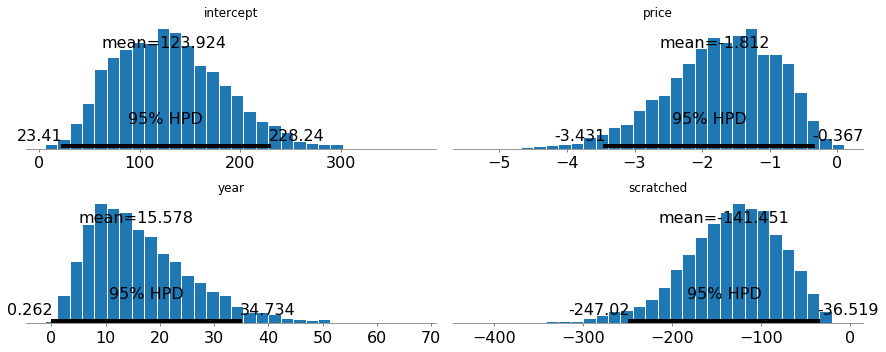

In [152]:
pm.plot_posterior(trace)

## Samples Taken
After running the code above we have done accomplished a number of things.  First, we've successfully modeled our data and determined distributions for the weights of our model as visualized above.  Any prior information we might have had could be plugged in the prior values of the weights, and then those weights were manipulated until the likelihood of the model began to match up with the data we had. 

The next step to define a loss function.  Note that our function actually returns the expected value over a number of samples that are drawn from our posterior given the inputs provided for the phone we're actually trying to see (year=2014, not scratched, for varied prices). 

Once we have a loss function, we'll consider a range of possible prices (between $10 and $110) and have our model predict if our phone would have sold at that price. 

In [159]:
def phone_sale_loss(input_price):
    # Input values of your phone
    year.set_value(np.array([3.], dtype=np.float32))
    scratched.set_value(np.array([0.], dtype=np.float32))
    price.set_value(np.array(input_price, dtype=np.float32))
    # Sample from posterior for our phone
    ppc = pm.sample_ppc(trace, model=logit_model, samples=500, progressbar=False)
    # Expected return
    return (ppc['obs_sales']*input_price).mean(), (ppc['obs_sales']*input_price).std()

In [160]:
price_vals = np.arange(10, 110, 1)
losses = [phone_sale_loss([_p])[0] for _p in price_vals]
losses_err = [phone_sale_loss([_p])[1] for _p in price_vals]

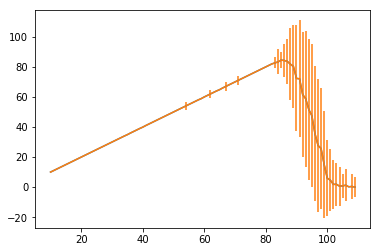

In [161]:
plt.plot(price_vals, losses)
plt.errorbar(x=price_vals, y=losses, yerr=losses_err)
plt.show()

In [127]:
sop.fmin(lambda x: -phone_sale_loss(x), 80)

Optimization terminated successfully.
         Current function value: -86.502449
         Iterations: 23
         Function evaluations: 59


array([ 86.50244904])

### Optimizing Loss
With a loss function working, we finally had a target to optimize.  As mentioned before, all we wanted to do was minimize our loss so we set the optimizing objective as the negative of our loss function.  After a few moments it returned that the best price for us to sell would be ~$86.